In [3]:
import pandas as pd
import numpy as np
import sqlite3
from plotnine import *
from mizani.formatters import comma_format, percent_format
from datetime import datetime

In [4]:
start_date = "01/01/1960"
end_date = "12/16/2024"

In [5]:
from sqlalchemy import create_engine


In [6]:
!pip install python-dotenv

In [7]:
!pip install wrds

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [12]:
from sqlalchemy import create_engine, text

# Directly input your WRDS username and password
username = ""  # Replace with your WRDS username
password = ""  # Replace with your WRDS password

# Connection string with hardcoded credentials
connection_string = (
    f"postgresql+psycopg2://{username}:{password}"
    "@wrds-pgdata.wharton.upenn.edu:9737/wrds?sslmode=require"
)

# Create the database engine
wrds = create_engine(connection_string, pool_pre_ping=True)

# Test the connection
try:
    # Use `text` to create a valid SQL query object
    with wrds.connect() as conn:
        result = conn.execute(text("SELECT CURRENT_DATE"))
        for row in result:
            print("Connection successful:", row)
except Exception as e:
    print("Connection failed:", e)


Connection successful: (datetime.date(2024, 12, 30),)


In [13]:
crsp_monthly_query = (
    "SELECT msf.permno, msf.mthcaldt AS date, "
    "date_trunc('month', msf.mthcaldt)::date AS month, "
    "msf.mthret AS ret, msf.shrout, msf.mthprc AS altprc, "
    "msf.primaryexch, msf.siccd "
    "FROM crsp.msf_v2 AS msf "
    "LEFT JOIN crsp.stksecurityinfohist AS ssih "
    "ON msf.permno = ssih.permno AND "
    "ssih.secinfostartdt <= msf.mthcaldt AND "
    "msf.mthcaldt <= ssih.secinfoenddt "
    f"WHERE msf.mthcaldt BETWEEN '{start_date}' AND '{end_date}' "
    "AND ssih.sharetype = 'NS' "
    "AND ssih.securitytype = 'EQTY' "
    "AND ssih.securitysubtype = 'COM' "
    "AND ssih.usincflg = 'Y' "
    "AND ssih.issuertype IN ('ACOR', 'CORP')"
)


In [14]:
crsp_monthly = (
    pd.read_sql_query(
        sql=crsp_monthly_query,
        con=wrds,
        dtype={"permno": int, "siccd": int},
        parse_dates=["date", "month"]  # Corrected to a list
    )
    .assign(shrout=lambda x: x["shrout"] * 1000)
)


In [15]:
crsp_monthly = (
    crsp_monthly
    .assign(mktcap=lambda x: x["shrout"] * x["altprc"] / 1000000)
    .assign(mktcap=lambda x: x["mktcap"].replace(0, np.nan))
)


In [16]:
mktcap_lag = (
    crsp_monthly
    .assign(
        month=lambda x: x["month"] + pd.DateOffset(months=1),
        mktcap_lag=lambda x: x["mktcap"]
    )
    .get(["permno", "month", "mktcap_lag"])
)

crsp_monthly = (
    crsp_monthly
    .merge(mktcap_lag, how="left", on=["permno", "month"])
)


In [17]:
def assign_exchange(primaryexch):
    if primaryexch == "N":
        return "NYSE"
    elif primaryexch == "A":
        return "AMEX"
    elif primaryexch == "Q":
        return "NASDAQ"
    else:
        return "Other"

crsp_monthly["exchange"] = (
    crsp_monthly["primaryexch"]
    .apply(assign_exchange)
)


In [18]:
def assign_industry(siccd):
    if 1 <= siccd <= 999:
        return "Agriculture"
    elif 1000 <= siccd <= 1499:
        return "Mining"
    elif 1500 <= siccd <= 1799:
        return "Construction"
    elif 2000 <= siccd <= 3999:
        return "Manufacturing"
    elif 4000 <= siccd <= 4899:
        return "Transportation"
    elif 4900 <= siccd <= 4999:
        return "Utilities"
    elif 5000 <= siccd <= 5199:
        return "Wholesale"
    elif 5200 <= siccd <= 5999:
        return "Retail"
    elif 6000 <= siccd <= 6799:
        return "Finance"
    elif 7000 <= siccd <= 8999:
        return "Services"
    elif 9000 <= siccd <= 9999:
        return "Public"
    else:
        return "Missing"

crsp_monthly["industry"] = (
    crsp_monthly["siccd"]
    .apply(assign_industry)
)


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
tidy_finance = sqlite3.connect(database="/content/drive/My Drive/tidy_finance_python.sqlite")

factors_ff3_monthly = pd.read_sql_query(
    sql="SELECT month, rf FROM factors_ff3_monthly",
    con=tidy_finance,
    parse_dates={"month"}
)

crsp_monthly = (
    crsp_monthly
    .merge(factors_ff3_monthly, how="left", on="month")
    .assign(ret_excess=lambda x: x["ret"] - x["rf"])
    .assign(ret_excess=lambda x: x["ret_excess"].clip(lower=-1))
    .drop(columns=["rf"])
)


In [22]:
factors_ff3_monthly

,month,rf
0,1960-01-01,0.0033
1,1960-02-01,0.0029
2,1960-03-01,0.0035
3,1960-04-01,0.0019
4,1960-05-01,0.0027
...,...,...
751,2022-08-01,0.0019
752,2022-09-01,0.0019
753,2022-10-01,0.0023
754,2022-11-01,0.0029


In [23]:
crsp_monthly = (crsp_monthly
.dropna(subset=["ret_excess", "mktcap", "mktcap_lag"])
)

In [24]:
(
    crsp_monthly
    .to_sql(
        name="crsp_monthly",
        con=tidy_finance,
        if_exists="replace",
        index=False
    )
)


3330470

/usr/local/lib/python3.10/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


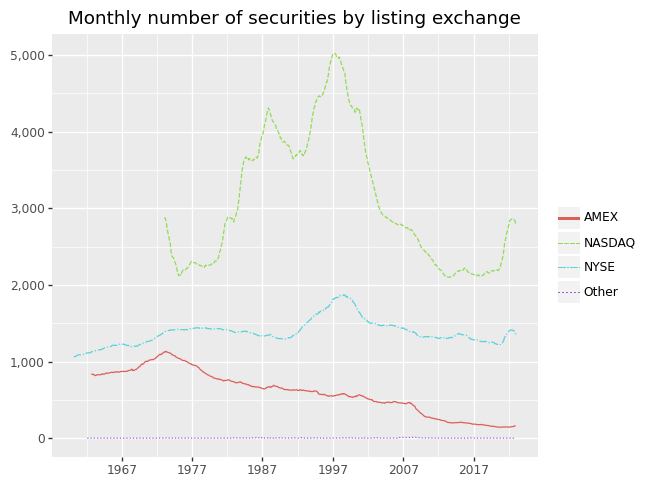

In [25]:
securities_per_exchange = (crsp_monthly
.groupby(["exchange", "date"])
.size()
.reset_index(name="n")
)
securities_per_exchange_figure = (
ggplot(securities_per_exchange,
aes(x="date", y="n", color="exchange", linetype="exchange")) +
geom_line() +
labs(x="", y="", color="", linetype="",
title="Monthly number of securities by listing exchange") +
scale_x_datetime(date_breaks="10 years", date_labels="%Y") +
scale_y_continuous(labels=comma_format())
)
securities_per_exchange_figure.draw()

<ipython-input-26-ae6ebab63fc8>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/usr/local/lib/python3.10/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


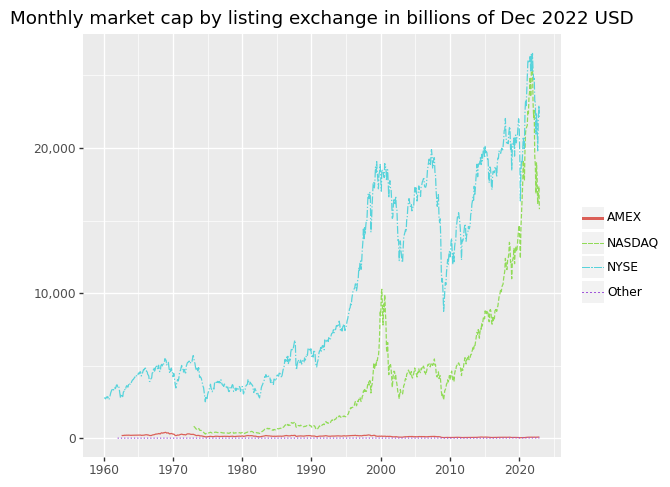

In [26]:
cpi_monthly = pd.read_sql_query(
sql="SELECT * FROM cpi_monthly",
con=tidy_finance,
parse_dates={"month"}
)
market_cap_per_exchange = (crsp_monthly
.merge(cpi_monthly, how="left", on="month")
.groupby(["month", "exchange"]).apply(
lambda group: pd.Series({
"mktcap": group["mktcap"].sum()/group["cpi"].mean()
})
)
.reset_index()
)
market_cap_per_exchange_figure = (
ggplot(market_cap_per_exchange,
aes(x="month", y="mktcap/1000",
color="exchange", linetype="exchange")) +
geom_line() +
labs(x="", y="", color="", linetype="",
title=("Monthly market cap by listing exchange "
"in billions of Dec 2022 USD")) +
scale_x_datetime(date_breaks="10 years", date_labels="%Y") +
scale_y_continuous(labels=comma_format())
)
market_cap_per_exchange_figure.draw()

/usr/local/lib/python3.10/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


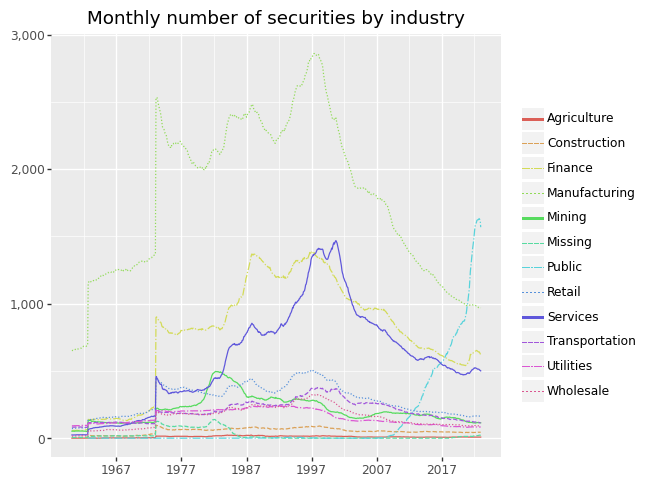

In [27]:
securities_per_industry = (crsp_monthly
.groupby(["industry", "date"])
.size()
.reset_index(name="n")
)
linetypes = ["-", "--", "-.", ":"]
n_industries = securities_per_industry["industry"].nunique()
securities_per_industry_figure = (
ggplot(securities_per_industry,
aes(x="date", y="n", color="industry", linetype="industry")) +
geom_line() +
labs(x="", y="", color="", linetype="",
title="Monthly number of securities by industry") +
scale_x_datetime(date_breaks="10 years", date_labels="%Y") +
scale_y_continuous(labels=comma_format()) +
scale_linetype_manual(
values=[linetypes[l % len(linetypes)] for l in range(n_industries)]
)
)
securities_per_industry_figure.draw()

<ipython-input-28-fc09fe622c6e>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/usr/local/lib/python3.10/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


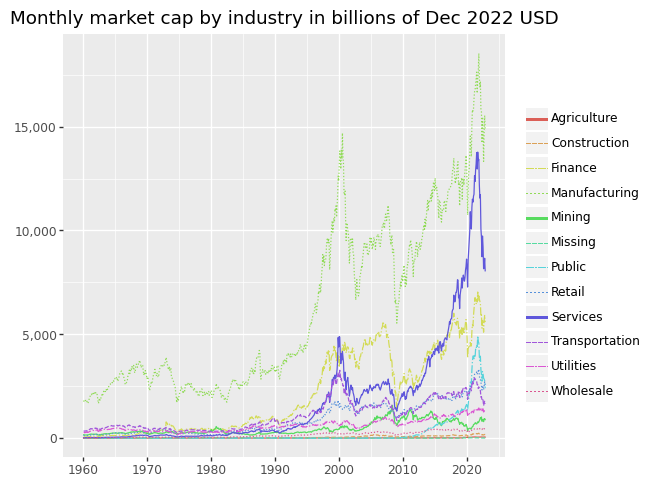

In [28]:
market_cap_per_industry = (crsp_monthly
.merge(cpi_monthly, how="left", on="month")
.groupby(["month", "industry"])
.apply(
lambda group: pd.Series({
"mktcap": (group["mktcap"].sum()/group["cpi"].mean())
})
)
.reset_index()
)
market_cap_per_industry_figure = (
ggplot(market_cap_per_industry,
aes(x="month", y="mktcap/1000",
color="industry", linetype="industry")) +
geom_line() +
labs(x="", y="", color="", linetype="",title="Monthly market cap by industry in billions of Dec 2022 USD") +
scale_x_datetime(date_breaks="10 years", date_labels="%Y") +
scale_y_continuous(labels=comma_format()) +
scale_linetype_manual(
values=[linetypes[l % len(linetypes)] for l in range(n_industries)]
)
)
market_cap_per_industry_figure.draw()

In [30]:
factors_ff3_daily = pd.read_sql(
    sql="SELECT * FROM factors_ff3_daily",
    con=tidy_finance,
    parse_dates={"date"}
)

permnos = list(crsp_monthly["permno"].unique().astype(str))

batch_size = 500
batches = np.ceil(len(permnos) / batch_size).astype(int)

for j in range(1, batches + 1):
    permno_batch = permnos[
        (j - 1) * batch_size : min(j * batch_size, len(permnos))
    ]

    permno_batch_formatted = ",".join(f"'{permno}'" for permno in permno_batch)
    permno_string = f"({permno_batch_formatted})"

    crsp_daily_sub_query = (
        f"SELECT permno, dlycaldt AS date, dlyret AS ret "
        f"FROM crsp.dsf_v2 "
        f"WHERE permno IN {permno_string} "
        f"AND dlycaldt BETWEEN '{start_date}' AND '{end_date}'"
    )

    crsp_daily_sub = (
        pd.read_sql_query(
            sql=crsp_daily_sub_query,
            con=wrds,
            dtype={"permno": int},
            parse_dates={"date"}
        )
        .dropna()
    )

    if not crsp_daily_sub.empty:
        crsp_daily_sub = (
            crsp_daily_sub
            .assign(
                month=lambda x: x["date"].dt.to_period("M").dt.to_timestamp()
            )
            .merge(factors_ff3_daily[["date", "rf"]], on="date", how="left")
            .assign(
                ret_excess=lambda x: (x["ret"] - x["rf"]).clip(lower=-1)
            )
            .get(["permno", "date", "month", "ret_excess"])
        )

        if j == 1:
            if_exists_string = "replace"
        else:
            if_exists_string = "append"

        crsp_daily_sub.to_sql(
            name="crsp_daily",
            con=tidy_finance,
            if_exists=if_exists_string,
            index=False
        )

    print(f"Batch {j} out of {batches} done ({(j/batches)*100:.2f}%)\n")


Batch 1 out of 52 done (1.92%)

Batch 2 out of 52 done (3.85%)

Batch 3 out of 52 done (5.77%)

Batch 4 out of 52 done (7.69%)

Batch 5 out of 52 done (9.62%)

Batch 6 out of 52 done (11.54%)

Batch 7 out of 52 done (13.46%)

Batch 8 out of 52 done (15.38%)

Batch 9 out of 52 done (17.31%)

Batch 10 out of 52 done (19.23%)

Batch 11 out of 52 done (21.15%)

Batch 12 out of 52 done (23.08%)

Batch 13 out of 52 done (25.00%)

Batch 14 out of 52 done (26.92%)

Batch 15 out of 52 done (28.85%)

Batch 16 out of 52 done (30.77%)

Batch 17 out of 52 done (32.69%)

Batch 18 out of 52 done (34.62%)

Batch 19 out of 52 done (36.54%)

Batch 20 out of 52 done (38.46%)

Batch 21 out of 52 done (40.38%)

Batch 22 out of 52 done (42.31%)

Batch 23 out of 52 done (44.23%)

Batch 24 out of 52 done (46.15%)

Batch 25 out of 52 done (48.08%)

Batch 26 out of 52 done (50.00%)

Batch 27 out of 52 done (51.92%)

Batch 28 out of 52 done (53.85%)

Batch 29 out of 52 done (55.77%)

Batch 30 out of 52 done (57.

In [31]:
compustat_query = (
"SELECT gvkey, datadate, seq, ceq, at, lt, txditc, txdb, itcb, pstkrv, "
"pstkl, pstk, capx, oancf, sale, cogs, xint, xsga "
"FROM comp.funda "
"WHERE indfmt = 'INDL' "
"AND datafmt = 'STD' "
"AND consol = 'C' "
f"AND datadate BETWEEN '{start_date}' AND '{end_date}'"
)
compustat = pd.read_sql_query(
sql=compustat_query,
con=wrds,
dtype={"gvkey": str},
parse_dates={"datadate"}
)

In [32]:
compustat = (compustat
.assign(
be=lambda x:
(x["seq"].combine_first(x["ceq"]+x["pstk"])
.combine_first(x["at"]-x["lt"])+
x["txditc"].combine_first(x["txdb"]+x["itcb"]).fillna(0)-
x["pstkrv"].combine_first(x["pstkl"])
.combine_first(x["pstk"]).fillna(0))
)
.assign(
be=lambda x: x["be"].apply(lambda y: np.nan if y <= 0 else y)
)
.assign(
op=lambda x:
((x["sale"]-x["cogs"].fillna(0)-
x["xsga"].fillna(0)-x["xint"].fillna(0))/x["be"])
)
)

In [33]:
compustat = (
    compustat
    .assign(year=lambda x: pd.DatetimeIndex(x["datadate"]).year)
    .sort_values("datadate")
    .groupby(["gvkey", "year"])
    .tail(1)
    .reset_index()
)


In [34]:
compustat_lag = (compustat
.get(["gvkey", "year", "at"])
.assign(year=lambda x: x["year"]+1)
.rename(columns={"at": "at_lag"})
)
compustat = (compustat
.merge(compustat_lag, how="left", on=["gvkey", "year"])
.assign(inv=lambda x: x["at"]/x["at_lag"]-1)
.assign(inv=lambda x: np.where(x["at_lag"] <= 0, np.nan, x["inv"]))
)

In [35]:
(compustat
.to_sql(name="compustat",
con=tidy_finance,
if_exists="replace",
index=False)
)

563982

In [36]:
ccmxpf_linktable_query = (
    "SELECT lpermno AS permno, gvkey, linkdt, "
    "COALESCE(linkenddt, CURRENT_DATE) AS linkenddt "
    "FROM crsp.ccmxpf_linktable "
    "WHERE linktype IN ('LU', 'LC') "
    "AND linkprim IN ('P', 'C') "
    "AND usedflag = 1"
)

ccmxpf_linktable = pd.read_sql_query(
    sql=ccmxpf_linktable_query,
    con=wrds,
    dtype={"permno": int, "gvkey": str},
    parse_dates=["linkdt", "linkenddt"]
)


In [37]:
ccm_links = (crsp_monthly
.merge(ccmxpf_linktable, how="inner", on="permno")
.query("~gvkey.isnull() & (date >= linkdt) & (date <= linkenddt)")
.get(["permno", "gvkey", "date"])
)
crsp_monthly = (crsp_monthly
.merge(ccm_links, how="left", on=["permno", "date"])
)

In [38]:
(crsp_monthly
.to_sql(name="crsp_monthly",
con=tidy_finance,
if_exists="replace",
index=False)
)

3330470

<ipython-input-39-473408933a8b>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


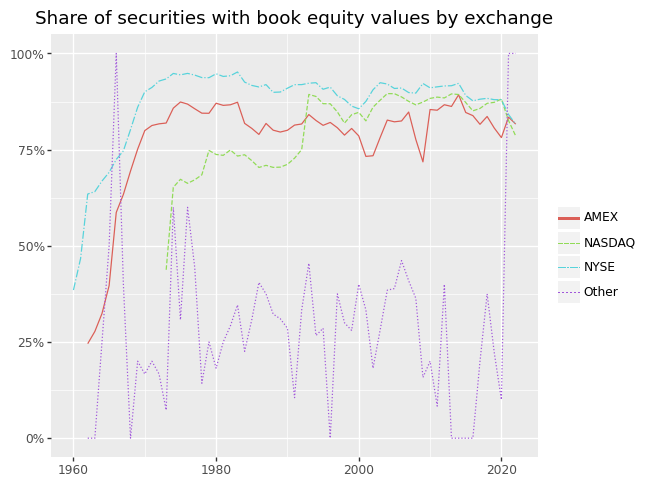

In [39]:
share_with_be = (
    crsp_monthly
    .assign(year=lambda x: pd.DatetimeIndex(x["month"]).year)
    .sort_values("date")
    .groupby(["permno", "year"])
    .tail(1)
    .reset_index()
    .merge(compustat, how="left", on=["gvkey", "year"])
    .groupby(["exchange", "year"])
    .apply(
        lambda x: pd.Series({
            "share": x["permno"][~x["be"].isnull()].nunique() / x["permno"].nunique()
        })
    )
    .reset_index()
)

share_with_be_figure = (
    ggplot(share_with_be, aes(x="year", y="share", color="exchange", linetype="exchange"))
    + geom_line()
    + labs(x="", y="", color="", linetype="", title="Share of securities with book equity values by exchange")
    + scale_y_continuous(labels=percent_format())
    + coord_cartesian(ylim=(0, 1))
)

share_with_be_figure.draw()


In [ ]:
#testing below

In [40]:
db_path_test = "/content/drive/My Drive/tidy_finance_python.sqlite"
conn = sqlite3.connect(db_path_test)

In [41]:
# Create a cursor object to execute queries
cursor = conn.cursor()

# Query to get the names of all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch and print the list of tables
tables = cursor.fetchall()
print("Tables in the database:", tables)


Tables in the database: [('factors_ff3_monthly',), ('factors_ff5_monthly',), ('factors_ff3_daily',), ('industries_ff_monthly',), ('factors_q_monthly',), ('macro_predictors',), ('cpi_monthly',), ('crsp_daily',), ('compustat',), ('crsp_monthly',)]


In [42]:
# Query the top 10 rows
cursor = conn.cursor()
cursor.execute("SELECT * FROM crsp_daily LIMIT 10;")
rows = cursor.fetchall()

# Print the rows
for row in rows:
    print(row)


(10000, '1986-01-08 00:00:00', '1986-01-01 00:00:00', -0.02464)
(10000, '1986-01-09 00:00:00', '1986-01-01 00:00:00', -0.00025)
(10000, '1986-01-10 00:00:00', '1986-01-01 00:00:00', -0.00025)
(10000, '1986-01-13 00:00:00', '1986-01-01 00:00:00', 0.04975)
(10000, '1986-01-14 00:00:00', '1986-01-01 00:00:00', 0.047369)
(10000, '1986-01-15 00:00:00', '1986-01-01 00:00:00', 0.045205)
(10000, '1986-01-16 00:00:00', '1986-01-01 00:00:00', 0.043228)
(10000, '1986-01-17 00:00:00', '1986-01-01 00:00:00', -0.00025)
(10000, '1986-01-20 00:00:00', '1986-01-01 00:00:00', -0.00025)
(10000, '1986-01-21 00:00:00', '1986-01-01 00:00:00', -0.00025)


In [43]:
# Query the top 10 rows from the compustat table
compustat_top10 = pd.read_sql_query("SELECT * FROM compustat LIMIT 10;", conn)

# Display the top 10 rows with headers
print(compustat_top10)


    index   gvkey             datadate   seq   ceq      at       lt  txditc  \
0  104175  006147  1960-01-31 00:00:00  None  None    29.6      NaN     NaN   
1  196894  011156  1960-01-31 00:00:00  None  None     3.5      NaN     NaN   
2   86741  005270  1960-01-31 00:00:00  None  None   181.6      NaN     NaN   
3  174782  009563  1960-01-31 00:00:00  None  None  2148.7  766.138     0.0   
4  122915  007068  1960-01-31 00:00:00  None  None   154.8      NaN     NaN   
5  107407  006303  1960-01-31 00:00:00  None  None     NaN      NaN     NaN   
6    6267  001301  1960-01-31 00:00:00  None  None   290.1  104.400     0.0   
7  169139  009294  1960-01-31 00:00:00  None  None     NaN      NaN     NaN   
8   72955  004611  1960-01-31 00:00:00  None  None   353.5  112.673     0.0   
9  149456  008446  1960-01-31 00:00:00  None  None   454.0  147.110     0.0   

   txdb  itcb  ...  oancf    sale     cogs   xint     xsga        be  \
0   NaN   NaN  ...   None    90.3    70.64   0.26    16.71

In [45]:
# Query the top 10 rows from the crsp_daily table
crsp_daily_10 = pd.read_sql_query("SELECT * FROM crsp_daily LIMIT 10;", conn)

# Display the top 10 rows with headers
print(crsp_daily_10)


   permno                 date                month  ret_excess
0   10000  1986-01-08 00:00:00  1986-01-01 00:00:00   -0.024640
1   10000  1986-01-09 00:00:00  1986-01-01 00:00:00   -0.000250
2   10000  1986-01-10 00:00:00  1986-01-01 00:00:00   -0.000250
3   10000  1986-01-13 00:00:00  1986-01-01 00:00:00    0.049750
4   10000  1986-01-14 00:00:00  1986-01-01 00:00:00    0.047369
5   10000  1986-01-15 00:00:00  1986-01-01 00:00:00    0.045205
6   10000  1986-01-16 00:00:00  1986-01-01 00:00:00    0.043228
7   10000  1986-01-17 00:00:00  1986-01-01 00:00:00   -0.000250
8   10000  1986-01-20 00:00:00  1986-01-01 00:00:00   -0.000250
9   10000  1986-01-21 00:00:00  1986-01-01 00:00:00   -0.000250


In [47]:
crsp_monthly_10 = pd.read_sql_query("SELECT count(*) FROM crsp_monthly;", conn)

# Count
print(crsp_monthly_10)

   count(*)
0   3330470


In [48]:
# Query the top 10 rows from the crsp_daily table
crsp_daily_10 = pd.read_sql_query("SELECT count(*) FROM crsp_daily;", conn)

# Row count
print(crsp_daily_10)

   count(*)
0  72170990
